In [1]:
library(terra)
library(sf)
library(spatstat)


terra 1.8.29


Warning message:
package ‘terra’ was built under R version 4.3.3 


Linking to GEOS 3.11.2, GDAL 3.6.2, PROJ 9.2.0; sf_use_s2() is TRUE
Loading required package: spatstat.data
Loading required package: spatstat.geom
spatstat.geom 3.2-1

Attaching package: ‘spatstat.geom’

The following objects are masked from ‘package:terra’:

    area, delaunay, is.empty, rescale, rotate, shift, where.max, where.min

Loading required package: spatstat.random
spatstat.random 3.1-5
Loading required package: spatstat.explore
Loading required package: nlme
spatstat.explore 3.2-1
Loading required package: spatstat.model
Loading required package: rpart
spatstat.model 3.2-4
Loading required package: spatstat.linnet
spatstat.linnet 3.1-1

spatstat 3.0-6 
For an introduction to spatstat, type ‘beginner’ 



Warning message:
package ‘spatstat.data’ was built under R version 4.3.3 


# 1. Data

In [23]:

# -------------------------
# 1) Cargar rasters (template = primer raster)
# -------------------------
beta_clusters <- rast("Results/raster/cluster_raster_result.tiff")  # template
richness      <- rast("Results/raster/GAM_prediction_alpha.tif")
endemism      <- rast("Results/GIE/Endemism_consensus.tiff")
ecu = st_read("Data/Shp/ecuador_limits.shp")
# -------------------------
# 2) Igualar CRS / resolución / extensión al template
# -------------------------
# (a) Proyectar a CRS del template (si hace falta)
if (!same.crs(richness, beta_clusters)) richness <- project(richness, beta_clusters)
if (!same.crs(endemism, beta_clusters)) endemism <- project(endemism, beta_clusters)

# (b) Ajustar extensión y resolución: resample al grid del template
richness_a <- resample(richness, beta_clusters, method = "bilinear")
endemism_a <- resample(endemism, beta_clusters, method = "bilinear")

# (opcional) recortar/maskar al extent exacto del template
richness_a <- crop(richness_a, beta_clusters)
endemism_a <- crop(endemism_a, beta_clusters)

# -------------------------
# 3) Leer puntos y construir "mapa de calor" (densidad por celda)
# -------------------------
insects_records <- read.csv("Data/Records/insects_records_clean.csv")

pts_sf <- st_as_sf(
  insects_records,
  coords = c("decimalLongitude","decimalLatitude"),
  crs = 4326,
  remove = FALSE
)



Reading layer `ecuador_limits' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\ecuador_limits.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.01115 ymin: -5.016157 xmax: -75.18715 ymax: 1.453982
Geodetic CRS:  WGS 84


# 2. Heatmap

Warning messages:
1: 2474 points were rejected as lying outside the specified window 
2: data contain duplicated points 


Número de puntos: 56098 
Extensión X: -81.01115 -75.17213 
Extensión Y: -5.016157 1.451683 
Densidad calculada en 0.1 segundos


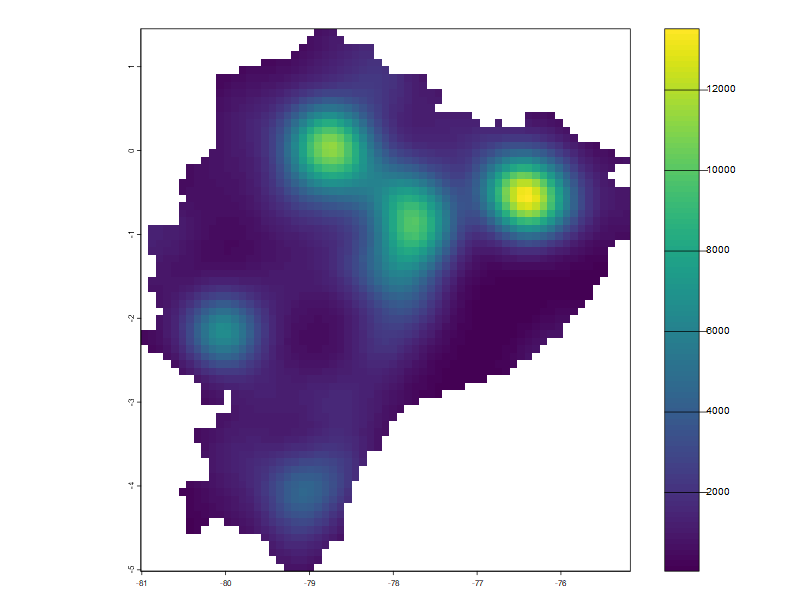

In [24]:
# -------------------------
# Densidad Kernel con bandwidth óptimo para CRS 4326
# Método: Diggle (Likelihood Cross-Validation)
# -------------------------

# Convertir a objeto ppp (point pattern) de spatstat
coords_proj <- st_coordinates(pts_sf)

# IMPORTANTE: Para CRS 4326, necesitamos una ventana apropiada
# Crear ventana desde la extensión del raster
ext_vals <- ext(beta_clusters)
window_bbox <- owin(
  xrange = c(ext_vals[1], ext_vals[2]),
  yrange = c(ext_vals[3], ext_vals[4])
)

# Crear objeto ppp
pts_ppp <- ppp(
  x = coords_proj[,1],
  y = coords_proj[,2],
  window = window_bbox
)

cat("Número de puntos:", npoints(pts_ppp), "\n")
cat("Extensión X:", window_bbox$xrange, "\n")
cat("Extensión Y:", window_bbox$yrange, "\n")



start_kde <- Sys.time()
sigma_manual <- 0.3  # ~1.1 km (20× más grande)

kde_suavizado <- density.ppp(
  pts_ppp,
  sigma = sigma_manual,
  dimyx = dim(beta_clusters)[1:2],
  edge = TRUE
)

end_kde <- Sys.time()
cat("Densidad calculada en", round(difftime(end_kde, start_kde, units = "secs"), 1), "segundos\n")

# Convertir a raster terra
kde_raster <- rast(kde_suavizado)
crs(kde_raster) <- crs(beta_clusters)

# Ajustar exactamente al template
kde_raster <- resample(kde_raster, beta_clusters, method = "bilinear")
kde_raster <- crop(kde_raster, beta_clusters)

names(kde_raster) <- "kernel_density_diggle"

# -------------------------
# Aplicar máscara de Ecuador
# -------------------------
kde_raster_ecu <- mask(kde_raster, ecu)

# -------------------------
# Visualización
# -------------------------
plot(kde_raster_ecu)

# -------------------------
# Guardar resultado
# -------------------------


writeRaster(
  kde_raster_ecu,
  "Results/raster/records_kernel_density.tiff",
  overwrite = TRUE,
  gdal = c("COMPRESS=LZW")
)

#
plot(kde_raster_ecu)
# -------------------------




# 3. Conservation importance areas

We analyze in each cluster obtained from beta diversity. In echa cluster we normalice from 0 to 1 the alpha diversity, endemism, and records raster. In the case of the last one we chance the meaning of the date with 0 in the pixels with the low highest density and 1 the pixels with the lowest, this is because we want to determinate the areas of majo importance and low data. 

We divide the analysis in alpha, endemism and both. 

## 3.1 Alpha diversity

In [ ]:

# ============================================================
# 0) Configuración de salida
# ============================================================
out_base <- "Results/raster"
out_dir  <- file.path(out_base, "alpha_diversity")

dir.create(out_base, recursive = TRUE, showWarnings = FALSE)
dir.create(out_dir,  recursive = TRUE, showWarnings = FALSE)

# ============================================================
# 1) Funciones auxiliares
# ============================================================

# Escalado 0–1 ignorando NA; devuelve NA si max==min o no hay datos
safe_scale01 <- function(x) {
  rr <- global(x, "range", na.rm = TRUE)
  mn <- rr[1, 1]
  mx <- rr[1, 2]

  if (is.na(mn) || is.na(mx) || mx == mn) return(x * NA)

  x01 <- (x - mn) / (mx - mn)
  clamp(x01, lower = 0, upper = 1, values = TRUE)
}

# Likert 1–5 sobre un raster 0–1 (intervalos iguales)
to_likert_5 <- function(x01) {
  # 0–0.2 -> 1, 0.2–0.4 -> 2, 0.4–0.6 -> 3, 0.6–0.8 -> 4, 0.8–1 -> 5
  rcl <- matrix(
    c(
      0.0, 0.2, 1,
      0.2, 0.4, 2,
      0.4, 0.6, 3,
      0.6, 0.8, 4,
      0.8, 1.0000001, 5
    ),
    ncol = 3, byrow = TRUE
  )
  classify(x01, rcl = rcl, include.lowest = TRUE, right = FALSE)
}

# ============================================================
# 2) Bucle por clúster: recorte, escalado, exportación
# ============================================================
avg_list <- vector("list", length = 3)

for (i in 1:3) {

  # 2.1) Máscara del clúster i (1 dentro; NA fuera)
  cluster_i <- ifel(beta_clusters == i, 1, NA)

  writeRaster(
    cluster_i,
    filename  = file.path(out_dir, paste0("cluster_mask_", i, ".tif")),
    overwrite = TRUE
  )

  # 2.2) Alpha (riqueza) recortada y escalada 0–1 dentro del clúster
  alpha_cluster <- mask(richness_a, cluster_i)
  alpha_cluster_scale <- safe_scale01(alpha_cluster)

  writeRaster(
    alpha_cluster_scale,
    filename  = file.path(out_dir, paste0("alpha_cluster_", i, "_scale.tif")),
    overwrite = TRUE
  )

  # 2.3) KDE recortada, escalada 0–1 e invertida (baja densidad -> valor alto)
  records_density_cluster <- mask(kde_raster_ecu, cluster_i)
  records_density_cluster_scale <- safe_scale01(records_density_cluster)

  records_density_cluster_scale_inv <- ifel(
    is.na(records_density_cluster_scale),
    NA,
    1 - records_density_cluster_scale
  )

  writeRaster(
    records_density_cluster_scale_inv,
    filename  = file.path(out_dir, paste0("records_density_cluster_", i, "_scale_inv.tif")),
    overwrite = TRUE
  )

  # 2.4) Promedio final por clúster
  alpha_conservation_cluster <- (alpha_cluster_scale + records_density_cluster_scale_inv) / 2

  writeRaster(
    alpha_conservation_cluster,
    filename  = file.path(out_dir, paste0("alpha_conservation_cluster_", i, "_avg.tif")),
    overwrite = TRUE
  )

  avg_list[[i]] <- alpha_conservation_cluster
}

# ============================================================
# 3) Unir promedios de clústeres en un solo raster
# ============================================================
alpha_conservation_all <- avg_list[[1]]
for (j in 2:length(avg_list)) {
  alpha_conservation_all <- cover(alpha_conservation_all, avg_list[[j]])
}

writeRaster(
  alpha_conservation_all,
  filename  = file.path(out_dir, "alpha_conservation_all_clusters_avg.tif"),
  overwrite = TRUE
)

# ============================================================
# 4) Escala Likert (1–5) aplicada al raster final y exportación
# ============================================================
# Si alpha_conservation_all ya está en 0–1, esto es directo.
# Si por alguna razón no lo está, re-escálalo antes:
alpha_conservation_all_01 <- safe_scale01(alpha_conservation_all)

alpha_conservation_all_likert5 <- to_likert_5(alpha_conservation_all_01)

writeRaster(
  alpha_conservation_all_01,
  filename  = file.path(out_dir, "alpha_conservation_all_clusters_avg_scale01.tif"),
  overwrite = TRUE
)

writeRaster(
  alpha_conservation_all_likert5,
  filename  = file.path(out_dir, "alpha_conservation_all_clusters_avg_likert5.tif"),
  overwrite = TRUE
)


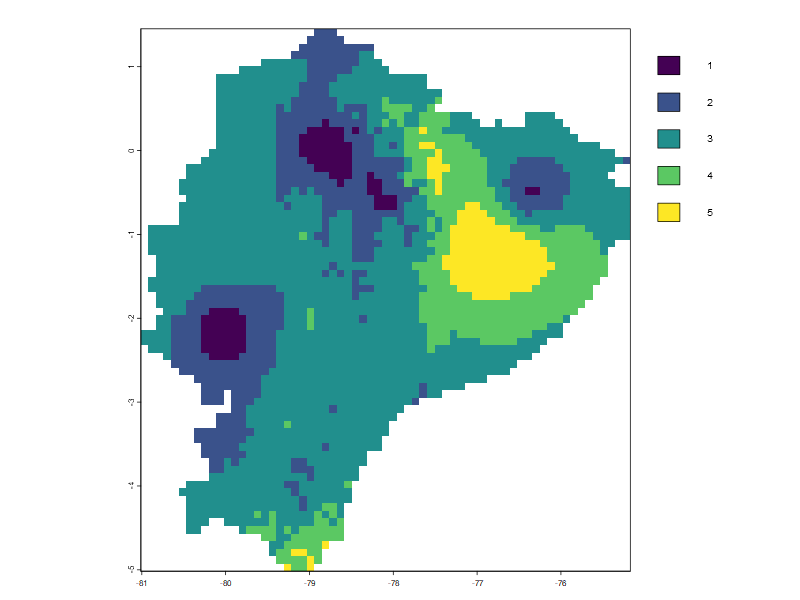

In [65]:
plot(alpha_conservation_all_likert5)

## 3.2. Endemism

In [ ]:

# ============================================================
# 0) Configuración de salida (ENDEMISMO)
# ============================================================
out_base <- "Results/raster"
out_dir  <- file.path(out_base, "endemism")

dir.create(out_base, recursive = TRUE, showWarnings = FALSE)
dir.create(out_dir,  recursive = TRUE, showWarnings = FALSE)

# ============================================================
# 1) Funciones auxiliares
# ============================================================

# Escalado 0–1 ignorando NA; devuelve NA si max==min o no hay datos
safe_scale01 <- function(x) {
  rr <- global(x, "range", na.rm = TRUE)
  mn <- rr[1, 1]
  mx <- rr[1, 2]

  if (is.na(mn) || is.na(mx) || mx == mn) return(x * NA)

  x01 <- (x - mn) / (mx - mn)
  clamp(x01, lower = 0, upper = 1, values = TRUE)
}

# Likert 1–5 sobre un raster 0–1 (intervalos iguales)
to_likert_5 <- function(x01) {
  rcl <- matrix(
    c(
      0.0, 0.2, 1,
      0.2, 0.4, 2,
      0.4, 0.6, 3,
      0.6, 0.8, 4,
      0.8, 1.0000001, 5
    ),
    ncol = 3, byrow = TRUE
  )
  classify(x01, rcl = rcl, include.lowest = TRUE, right = FALSE)
}

# ============================================================
# 2) Bucle por clúster: recorte (endemismo), escalado, exportación
# ============================================================
avg_list <- vector("list", length = 3)

for (i in 1:3) {

  # 2.1) Máscara del clúster i (1 dentro; NA fuera)
  cluster_i <- ifel(beta_clusters == i, 1, NA)

  writeRaster(
    cluster_i,
    filename  = file.path(out_dir, paste0("cluster_mask_", i, ".tif")),
    overwrite = TRUE
  )

  # 2.2) Endemismo recortado y escalado 0–1 dentro del clúster
  endemism_cluster <- mask(endemism_a, cluster_i)
  endemism_cluster_scale <- safe_scale01(endemism_cluster)

  writeRaster(
    endemism_cluster_scale,
    filename  = file.path(out_dir, paste0("endemism_cluster_", i, "_scale.tif")),
    overwrite = TRUE
  )

  # 2.3) KDE recortada, escalada 0–1 e invertida (baja densidad -> valor alto)
  records_density_cluster <- mask(kde_raster_ecu, cluster_i)
  records_density_cluster_scale <- safe_scale01(records_density_cluster)

  records_density_cluster_scale_inv <- ifel(
    is.na(records_density_cluster_scale),
    NA,
    1 - records_density_cluster_scale
  )

  writeRaster(
    records_density_cluster_scale_inv,
    filename  = file.path(out_dir, paste0("records_density_cluster_", i, "_scale_inv.tif")),
    overwrite = TRUE
  )

  # 2.4) Promedio final por clúster (endemismo + densidad invertida)
  endemism_conservation_cluster <- (endemism_cluster_scale + records_density_cluster_scale_inv) / 2

  writeRaster(
    endemism_conservation_cluster,
    filename  = file.path(out_dir, paste0("endemism_conservation_cluster_", i, "_avg.tif")),
    overwrite = TRUE
  )

  avg_list[[i]] <- endemism_conservation_cluster
}

# ============================================================
# 3) Unir promedios de clústeres en un solo raster
# ============================================================
endemism_conservation_all <- avg_list[[1]]
for (j in 2:length(avg_list)) {
  endemism_conservation_all <- cover(endemism_conservation_all, avg_list[[j]])
}

writeRaster(
  endemism_conservation_all,
  filename  = file.path(out_dir, "endemism_conservation_all_clusters_avg.tif"),
  overwrite = TRUE
)

# ============================================================
# 4) Escala 0–1 y Likert (1–5) aplicada al raster final y exportación
# ============================================================
endemism_conservation_all_01 <- safe_scale01(endemism_conservation_all)
endemism_conservation_all_likert5 <- to_likert_5(endemism_conservation_all_01)

writeRaster(
  endemism_conservation_all_01,
  filename  = file.path(out_dir, "endemism_conservation_all_clusters_avg_scale01.tif"),
  overwrite = TRUE
)

writeRaster(
  endemism_conservation_all_likert5,
  filename  = file.path(out_dir, "endemism_conservation_all_clusters_avg_likert5.tif"),
  overwrite = TRUE
)


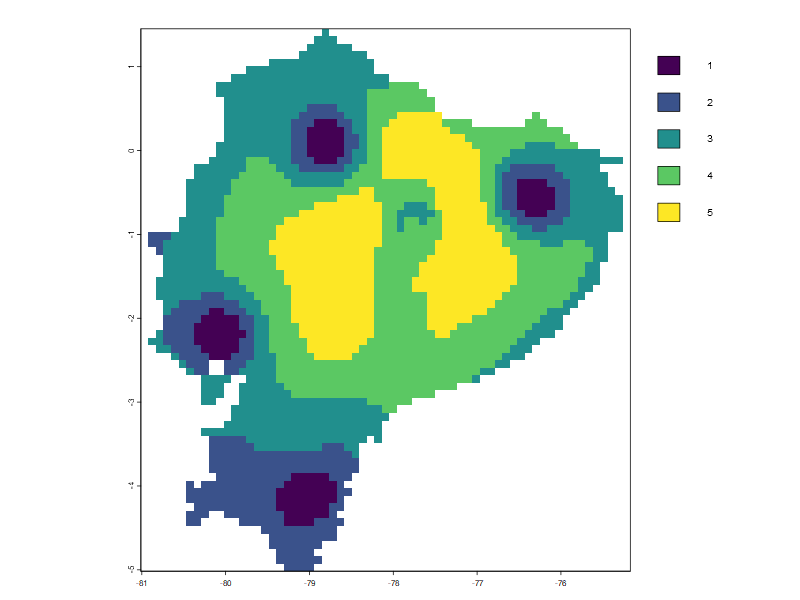

In [67]:
plot(endemism_conservation_all_likert5)

## 3.3. Alpha and Endemism

In [ ]:

# ============================================================
# 0) Configuración de salida (ALPHA + ENDEMISMO + RECORDS)
# ============================================================
out_base <- "Results/raster"
out_dir  <- file.path(out_base, "alpha_endemism_records")

dir.create(out_base, recursive = TRUE, showWarnings = FALSE)
dir.create(out_dir,  recursive = TRUE, showWarnings = FALSE)

# ============================================================
# 1) Funciones auxiliares
# ============================================================

# Escalado 0–1 ignorando NA; devuelve NA si max==min o no hay datos
safe_scale01 <- function(x) {
  rr <- global(x, "range", na.rm = TRUE)
  mn <- rr[1, 1]
  mx <- rr[1, 2]
  if (is.na(mn) || is.na(mx) || mx == mn) return(x * NA)
  x01 <- (x - mn) / (mx - mn)
  clamp(x01, lower = 0, upper = 1, values = TRUE)
}

# Likert 1–5 sobre un raster 0–1 (intervalos iguales)
to_likert_5 <- function(x01) {
  rcl <- matrix(
    c(
      0.0, 0.2, 1,
      0.2, 0.4, 2,
      0.4, 0.6, 3,
      0.6, 0.8, 4,
      0.8, 1.0000001, 5
    ),
    ncol = 3, byrow = TRUE
  )
  classify(x01, rcl = rcl, include.lowest = TRUE, right = FALSE)
}

# ============================================================
# 2) Bucle por clúster: recorte, escalado, promedio triple
# ============================================================
avg_list <- vector("list", length = 3)

for (i in 1:3) {

  # 2.1) Máscara del clúster i
  cluster_i <- ifel(beta_clusters == i, 1, NA)

  writeRaster(
    cluster_i,
    filename  = file.path(out_dir, paste0("cluster_mask_", i, ".tif")),
    overwrite = TRUE
  )

  # 2.2) Alpha (riqueza) recortada y escalada 0–1
  alpha_cluster <- mask(richness_a, cluster_i)
  alpha_scale <- safe_scale01(alpha_cluster)

  writeRaster(
    alpha_scale,
    filename  = file.path(out_dir, paste0("alpha_cluster_", i, "_scale.tif")),
    overwrite = TRUE
  )

  # 2.3) Endemismo recortado y escalado 0–1
  endemism_cluster <- mask(endemism_a, cluster_i)
  endemism_scale <- safe_scale01(endemism_cluster)

  writeRaster(
    endemism_scale,
    filename  = file.path(out_dir, paste0("endemism_cluster_", i, "_scale.tif")),
    overwrite = TRUE
  )

  # 2.4) KDE recortada, escalada 0–1 e invertida (baja densidad -> valor alto)
  records_cluster <- mask(kde_raster_ecu, cluster_i)
  records_scale <- safe_scale01(records_cluster)

  records_scale_inv <- ifel(
    is.na(records_scale),
    NA,
    1 - records_scale
  )

  writeRaster(
    records_scale_inv,
    filename  = file.path(out_dir, paste0("records_density_cluster_", i, "_scale_inv.tif")),
    overwrite = TRUE
  )

  # 2.5) Promedio triple por clúster (alpha + endemismo + records_inv) / 3
  alpha_endemism_records_cluster <- (alpha_scale + endemism_scale + records_scale_inv) / 3

  writeRaster(
    alpha_endemism_records_cluster,
    filename  = file.path(out_dir, paste0("alpha_endemism_records_cluster_", i, "_avg.tif")),
    overwrite = TRUE
  )

  avg_list[[i]] <- alpha_endemism_records_cluster
}

# ============================================================
# 3) Unir clústeres en un solo raster
# ============================================================
alpha_endemism_records_all <- avg_list[[1]]
for (j in 2:length(avg_list)) {
  alpha_endemism_records_all <- cover(alpha_endemism_records_all, avg_list[[j]])
}

writeRaster(
  alpha_endemism_records_all,
  filename  = file.path(out_dir, "alpha_endemism_records_all_clusters_avg.tif"),
  overwrite = TRUE
)

# ============================================================
# 4) Escala 0–1 global + Likert (1–5) y exportación
# ============================================================
alpha_endemism_records_all_01 <- safe_scale01(alpha_endemism_records_all)
alpha_endemism_records_all_likert5 <- to_likert_5(alpha_endemism_records_all_01)

writeRaster(
  alpha_endemism_records_all_01,
  filename  = file.path(out_dir, "alpha_endemism_records_all_clusters_avg_scale01.tif"),
  overwrite = TRUE
)

writeRaster(
  alpha_endemism_records_all_likert5,
  filename  = file.path(out_dir, "alpha_endemism_records_all_clusters_avg_likert5.tif"),
  overwrite = TRUE
)


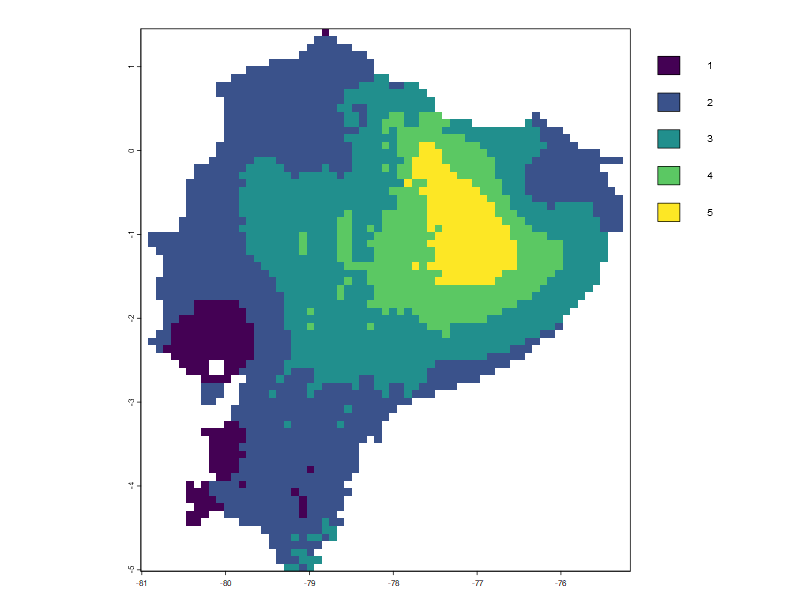

In [69]:
plot(alpha_endemism_records_all_likert5)